<a href="https://colab.research.google.com/github/jotafeldmann/tcc-ia-big-data/blob/main/tcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulando multi-agentes em jogos de tabuleiro por turnos, utilizando aprendizagem por reforço via Value-Decomposition Network e Gymnasium API


**Autor: Jorge Feldmann**

Este é o notebook que acompanha o TCC de mesmo nome.


# Configurando o ambiente

In [ ]:
!pip install --root-user-action=ignore 'pip<=23.0.1'
!pip install --root-user-action=ignore 'setuptools<=66'
!pip install --root-user-action=ignore 'wheel<=0.38.4'
!pip install --root-user-action=ignore ma-gym==0.0.8

In [ ]:
env_name = 'ma_gym:PredatorPrey5x5-v1'
project_name = 'tcc'

# Configurar IS_DEBUG=True para modo de debug
IS_DEBUG = True

# Jogo

## Configuração

In [ ]:
!apt-get install x11-utils
!pip install pyglet
!apt-get install -y xvfb
!apt-get install -y python3-opengl
!pip install --root-user-action=ignore gym pyvirtualdisplay

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxkbfile1 libxtst6 libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libfontenc1 libxkbfile1 libxtst6 libxxf86dga1 x11-utils
0 upgraded, 5 newly installed, 0 to remove and 16 not upgraded.
Need to get 318 kB of archives.
After this operation, 1,053 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1.1.0-1build3 [71.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxtst6 amd64 2:1.2.3-1build4 [13.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxxf86dga1 amd64 2:1.1.5-0ubuntu3 [12.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/main amd64 x11-utils amd64 7.7+5build2 [206 kB]
Fetched

In [ ]:
%set_env preview_path /content/preview
! echo $preview_path

%mkdir $preview_path

import os
preview_path = os.getenv('preview_path')
print(preview_path)

env: preview_path=/content/preview
/content/preview
mkdir: cannot create directory ‘/content/preview’: File exists
/content/preview


In [ ]:
import os
import imageio
import numpy as np
from PIL import Image as ijota
import PIL.ImageDraw as ImageDraw
import matplotlib.pyplot as plt
import gym
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()


def _label_with_episode_number(frame, episode_num):
    im = ijota.fromarray(frame)

    drawer = ImageDraw.Draw(im)

    if np.mean(im) < 128:
        text_color = (255,255,255)
    else:
        text_color = (0,0,0)
    drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode_num}', fill=text_color)

    return im

env = gym.make(env_name)
done_n = [False for _ in range(env.n_agents)]
ep_reward = 0

obs_n = env.reset()
frames = []
epi = 1
preview_file_path = os.path.join(preview_path, 'preview.gif')

while not all(done_n):
    frame = env.render(mode='rgb_array')
    frames.append(_label_with_episode_number(frame, episode_num=epi))
    obs_n, reward_n, done_n, info = env.step(env.action_space.sample())
    screen = env.render(mode='rgb_array')
    ep_reward += sum(reward_n)

imageio.mimwrite(preview_file_path, frames, duration=1)
env.close()

## Prévia visual

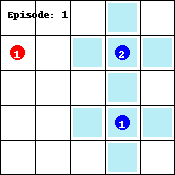

In [ ]:
from IPython.display import Image
Image(open(preview_file_path,'rb').read())

# Treino e teste

In [ ]:
import collections

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

episodes_info = []

class ReplayBuffer:
    def __init__(self, buffer_limit):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample_chunk(self, batch_size, chunk_size):
        start_idx = np.random.randint(0, len(self.buffer) - chunk_size, batch_size)
        s_lst, a_lst, r_lst, s_prime_lst, done_lst = [], [], [], [], []

        for idx in start_idx:
            for chunk_step in range(idx, idx + chunk_size):
                s, a, r, s_prime, done = self.buffer[chunk_step]
                s_lst.append(s)
                a_lst.append(a)
                r_lst.append(r)
                s_prime_lst.append(s_prime)
                done_lst.append(done)

        n_agents, obs_size = len(s_lst[0]), len(s_lst[0][0])
        return torch.tensor(s_lst, dtype=torch.float).view(batch_size, chunk_size, n_agents, obs_size), \
               torch.tensor(a_lst, dtype=torch.float).view(batch_size, chunk_size, n_agents), \
               torch.tensor(r_lst, dtype=torch.float).view(batch_size, chunk_size, n_agents), \
               torch.tensor(s_prime_lst, dtype=torch.float).view(batch_size, chunk_size, n_agents, obs_size), \
               torch.tensor(done_lst, dtype=torch.float).view(batch_size, chunk_size, 1)

    def size(self):
        return len(self.buffer)


class QNet(nn.Module):
    def __init__(self, observation_space, action_space, recurrent=False):
        super(QNet, self).__init__()
        self.num_agents = len(observation_space)
        self.recurrent = recurrent
        self.hx_size = 32
        for agent_i in range(self.num_agents):
            n_obs = observation_space[agent_i].shape[0]
            setattr(self, 'agent_feature_{}'.format(agent_i), nn.Sequential(nn.Linear(n_obs, 64),
                                                                            nn.ReLU(),
                                                                            nn.Linear(64, self.hx_size),
                                                                            nn.ReLU()))
            if recurrent:
                setattr(self, 'agent_gru_{}'.format(agent_i), nn.GRUCell(self.hx_size, self.hx_size))
            setattr(self, 'agent_q_{}'.format(agent_i), nn.Linear(self.hx_size, action_space[agent_i].n))

    def forward(self, obs, hidden):
        q_values = [torch.empty(obs.shape[0], )] * self.num_agents
        next_hidden = [torch.empty(obs.shape[0], 1, self.hx_size)] * self.num_agents
        for agent_i in range(self.num_agents):
            x = getattr(self, 'agent_feature_{}'.format(agent_i))(obs[:, agent_i, :])
            if self.recurrent:
                x = getattr(self, 'agent_gru_{}'.format(agent_i))(x, hidden[:, agent_i, :])
                next_hidden[agent_i] = x.unsqueeze(1)
            q_values[agent_i] = getattr(self, 'agent_q_{}'.format(agent_i))(x).unsqueeze(1)

        return torch.cat(q_values, dim=1), torch.cat(next_hidden, dim=1)

    def sample_action(self, obs, hidden, epsilon):
        out, hidden = self.forward(obs, hidden)
        mask = (torch.rand((out.shape[0],)) <= epsilon)
        action = torch.empty((out.shape[0], out.shape[1],))
        action[mask] = torch.randint(0, out.shape[2], action[mask].shape).float()
        action[~mask] = out[~mask].argmax(dim=2).float()
        return action, hidden

    def init_hidden(self, batch_size=1):
        return torch.zeros((batch_size, self.num_agents, self.hx_size))


def train(q, q_target, memory, optimizer, gamma, batch_size, update_iter=10, chunk_size=10, grad_clip_norm=5):
    _chunk_size = chunk_size if q.recurrent else 1
    for _ in range(update_iter):
        s, a, r, s_prime, done = memory.sample_chunk(batch_size, _chunk_size)

        hidden = q.init_hidden(batch_size)
        target_hidden = q_target.init_hidden(batch_size)
        loss = 0
        for step_i in range(_chunk_size):
            q_out, hidden = q(s[:, step_i, :, :], hidden)
            q_a = q_out.gather(2, a[:, step_i, :].unsqueeze(-1).long()).squeeze(-1)
            sum_q = q_a.sum(dim=1, keepdims=True)

            max_q_prime, target_hidden = q_target(s_prime[:, step_i, :, :], target_hidden.detach())
            max_q_prime = max_q_prime.max(dim=2)[0].squeeze(-1)
            target_q = r[:, step_i, :].sum(dim=1, keepdims=True)
            target_q += gamma * max_q_prime.sum(dim=1, keepdims=True) * (1 - done[:, step_i])

            loss += F.smooth_l1_loss(sum_q, target_q.detach())

            done_mask = done[:, step_i].squeeze(-1).bool()
            hidden[done_mask] = q.init_hidden(len(hidden[done_mask]))
            target_hidden[done_mask] = q_target.init_hidden(len(target_hidden[done_mask]))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(q.parameters(), grad_clip_norm, norm_type=2)
        optimizer.step()


def test(env, num_episodes, q):
    score = 0
    for episode_i in range(num_episodes):
        state = env.reset()
        done = [False for _ in range(env.n_agents)]
        with torch.no_grad():
            hidden = q.init_hidden()
            while not all(done):
                action, hidden = q.sample_action(torch.Tensor(state).unsqueeze(0), hidden, epsilon=0)
                next_state, reward, done, info = env.step(action[0].data.cpu().numpy().tolist())
                score += sum(reward)
                state = next_state

    return score / num_episodes


def main(env_name, lr, gamma, batch_size, buffer_limit, log_interval, max_episodes, max_epsilon, min_epsilon,
         test_episodes, warm_up_steps, update_iter, chunk_size, update_target_interval, recurrent):

    # create env.
    env = gym.make(env_name)
    test_env = gym.make(env_name)
    memory = ReplayBuffer(buffer_limit)

    # create networks
    q = QNet(env.observation_space, env.action_space, recurrent)
    q_target = QNet(env.observation_space, env.action_space, recurrent)
    q_target.load_state_dict(q.state_dict())
    optimizer = optim.Adam(q.parameters(), lr=lr)

    score = 0
    for episode_i in range(max_episodes):
        epsilon = max(min_epsilon, max_epsilon - (max_epsilon - min_epsilon) * (episode_i / (0.6 * max_episodes)))
        state = env.reset()
        done = [False for _ in range(env.n_agents)]
        with torch.no_grad():
            hidden = q.init_hidden()
            while not all(done):
                action, hidden = q.sample_action(torch.Tensor(state).unsqueeze(0), hidden, epsilon)
                action = action[0].data.cpu().numpy().tolist()
                next_state, reward, done, info = env.step(action)
                memory.put((state, action, (np.array(reward)).tolist(), next_state, [int(all(done))]))
                score += sum(reward)
                state = next_state

        if memory.size() > warm_up_steps:
            train(q, q_target, memory, optimizer, gamma, batch_size, update_iter, chunk_size)

        if episode_i % update_target_interval:
            q_target.load_state_dict(q.state_dict())

        if (episode_i + 1) % log_interval == 0:
            test_score = test(test_env, test_episodes, q)
            train_score = score / log_interval
            score = 0

            if IS_DEBUG:
                print("#{:<10}/{} episodes , avg train score : {:.1f}, test score: {:.1f} n_buffer : {}, eps : {:.1f}"
                .format(episode_i, max_episodes, train_score, test_score, memory.size(), epsilon))

            info = {'episode': episode_i, 'test-score': test_score, 'buffer-size': memory.size(),
                           'epsilon': epsilon, 'train-score': train_score}

            episodes_info.append(info)

    env.close()
    test_env.close()

## Execução

In [ ]:
if IS_DEBUG:
    max_episodes = 10
    log_interval = 1
else:
    max_episodes = 15000
    log_interval = 100

kwargs = {
    'env_name': env_name,
    'lr': 0.001,
    'batch_size': 32,
    'gamma': 0.99,
    'buffer_limit': 50000,
    'update_target_interval': 20,
    'log_interval': log_interval,
    'max_episodes': max_episodes,
    'max_epsilon': 0.9,
    'min_epsilon': 0.1,
    'test_episodes': 5,
    'warm_up_steps': 2000,
    'update_iter': 10,
    'chunk_size': 10,
    'recurrent': True
}

main(**kwargs)

#0         /10 episodes , avg train score : -3.8, test score: 0.2 n_buffer : 42, eps : 0.9
#1         /10 episodes , avg train score : 4.6, test score: -3.6 n_buffer : 62, eps : 0.8
#2         /10 episodes , avg train score : -8.0, test score: -3.4 n_buffer : 162, eps : 0.6
#3         /10 episodes , avg train score : -7.0, test score: -3.0 n_buffer : 262, eps : 0.5
#4         /10 episodes , avg train score : -13.0, test score: -3.0 n_buffer : 362, eps : 0.4
#5         /10 episodes , avg train score : -2.0, test score: -4.6 n_buffer : 462, eps : 0.2
#6         /10 episodes , avg train score : -6.0, test score: -4.2 n_buffer : 562, eps : 0.1
#7         /10 episodes , avg train score : 8.9, test score: -2.4 n_buffer : 565, eps : 0.1
#8         /10 episodes , avg train score : -3.0, test score: -2.2 n_buffer : 665, eps : 0.1
#9         /10 episodes , avg train score : -3.0, test score: -3.0 n_buffer : 765, eps : 0.1


# Relatório

,episode,test-score,buffer-size,epsilon,train-score
0,0,-2.400,81,0.900000,-11.62
1,1,-0.016,160,0.766667,3.42
2,2,-2.800,260,0.633333,-7.00
3,3,-3.800,360,0.500000,-8.00
4,4,-2.600,460,0.366667,-12.00
5,5,-2.600,560,0.233333,-3.00
6,6,-2.000,660,0.100000,-2.00
7,7,-2.800,760,0.100000,-7.00
8,8,-2.200,860,0.100000,-4.00
9,9,-2.000,960,0.100000,-3.00


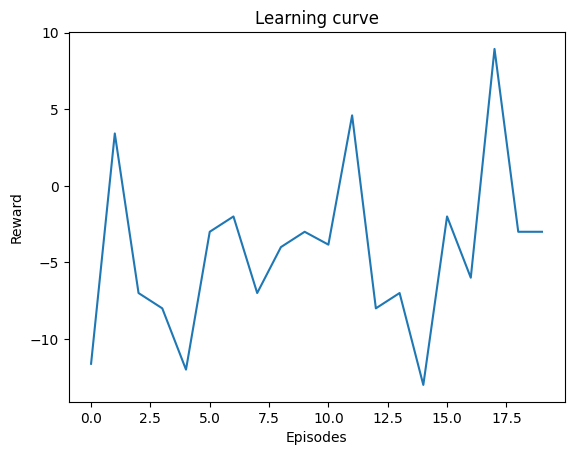

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.DataFrame(episodes_info)
display(df)

plt.plot(df['train-score'])
plt.title('Learning curve')
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()